# CISC499: UNDERGRADUATE RESEARCH PROJECT

## LOAD LIBRARIES

In [ ]:
import cv2
import os
import re
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## CNN-BASED APPROACH

In [ ]:
src_path = "/content/drive/MyDrive/cisc499/original_images"
carotid_data = pd.read_excel(os.path.join('/content/drive/MyDrive/cisc499/CarotidData-Ver3.xlsx'), skipfooter=7, usecols="A,BU", engine='openpyxl')

In [ ]:
IMG_HEIGHT = 350
IMG_WIDTH = 350
BATCH_SIZE = 32

In [ ]:
def getSetsExcel(pathToData, bulb):
  train_data_right = pd.read_excel(os.path.join('/content/drive/MyDrive/cisc499/MASK-train_val_test_split.xlsx'), sheet_name="Train - Right Bulb", engine='openpyxl') 
  train_data_right['label'] = train_data_right['label'].astype(str)
  for id in train_data_right['filename']:
    train_data_right['filename'] = train_data_right['filename'].replace([id], glob.glob(os.path.join(src_path + '/right_images/' + "*" + str(id) + "*"))[0])
  
  val_data_right = pd.read_excel(os.path.join('/content/drive/MyDrive/cisc499/MASK-train_val_test_split.xlsx'), sheet_name="Val - Right Bulb", engine='openpyxl') 
  val_data_right['label'] = val_data_right['label'].astype(str)
  for id in val_data_right['filename']:
    val_data_right['filename'] = val_data_right['filename'].replace([id], glob.glob(os.path.join(src_path + '/right_images/' + "*" + str(id) + "*"))[0])
  
  test_data_right = pd.read_excel(os.path.join('/content/drive/MyDrive/cisc499/MASK-train_val_test_split.xlsx'), sheet_name="Test - Right Bulb", engine='openpyxl') 
  test_data_right['label'] = test_data_right['label'].astype(str)
  for id in test_data_right['filename']:
    test_data_right['filename'] = test_data_right['filename'].replace([id], glob.glob(os.path.join(src_path + '/right_images/' + "*" + str(id) + "*"))[0])

  train_data_left = pd.read_excel(os.path.join('/content/drive/MyDrive/cisc499/MASK-train_val_test_split.xlsx'), sheet_name="Train - Left Bulb", engine='openpyxl') 
  train_data_left['label'] = train_data_left['label'].astype(str)
  for id in train_data_left['filename']:
    train_data_left['filename'] = train_data_left['filename'].replace([id], glob.glob(os.path.join(src_path + '/left_images/' + "*" + str(id) + "*"))[0])

  val_data_left = pd.read_excel(os.path.join('/content/drive/MyDrive/cisc499/MASK-train_val_test_split.xlsx'), sheet_name="Val - Left Bulb", engine='openpyxl') 
  val_data_left['label'] = val_data_left['label'].astype(str)
  for id in val_data_left['filename']:
    val_data_left['filename'] = val_data_left['filename'].replace([id], glob.glob(os.path.join(src_path + '/left_images/' + "*" + str(id) + "*"))[0])

  test_data_left = pd.read_excel(os.path.join('/content/drive/MyDrive/cisc499/MASK-train_val_test_split.xlsx'), sheet_name="Test - Left Bulb", engine='openpyxl') 
  test_data_left['label'] = test_data_left['label'].astype(str)
  for id in test_data_left['filename']:
    test_data_left['filename'] = test_data_left['filename'].replace([id], glob.glob(os.path.join(src_path + '/left_images/' + "*" + str(id) + "*"))[0])

  if bulb == "right":
    return train_data_right, val_data_right, test_data_right
  else:
    return train_data_left, val_data_left, test_data_left


In [ ]:
def createModel():
  model = keras.Sequential()

  # Convolutional layer and maxpool layer 1
  model.add(keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH,1)))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.MaxPool2D(2,2))

  # Convolutional layer and maxpool layer 2
  model.add(keras.layers.Conv2D(32,(3,3),activation='relu'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.MaxPool2D(2,2))

  # Convolutional layer and maxpool layer 3
  model.add(keras.layers.Conv2D(32,(3,3),activation='relu'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.MaxPool2D(2,2))

  # Convolutional layer and maxpool layer 4
  model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.MaxPool2D(2,2))

  # Convolutional layer and maxpool layer 5
  model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.MaxPool2D(2,2))

  # This layer flattens the resulting image array to 1D array
  model.add(keras.layers.Flatten())

  # Hidden layer with 400 neurons and Rectified Linear Unit activation function 
  model.add(keras.layers.Dense(400,activation='relu'))
  model.add(Dropout(0.5))

  # Output layer with single neuron
  #Here we use sigmoid activation function which makes our model output to lie between 0 and 1
  model.add(keras.layers.Dense(1,activation='sigmoid'))

  opt = tf.keras.optimizers.Adam(learning_rate=0.01)
  model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

  return model

#### LOAD DATA

In [ ]:
train_data, val_data, test_data = getSetsExcel(src_path, "left")

Train: ratio of class 0 to class 1: 1.61:1


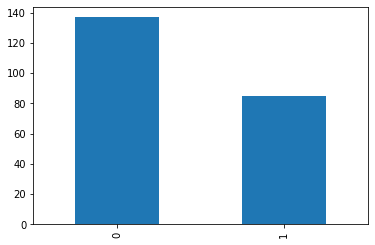

In [ ]:
# View distribution of classes in each set
train_data['label'].value_counts().plot.bar()

train_0 = len(train_data['label']) - sum(map(int, train_data['label']))
train_1 = sum(map(int, train_data['label']))
print("Train: ratio of class 0 to class 1: {0}:1".format(round(train_0/train_1,2)))

Val: ratio of class 0 to class 1: 1.59:1


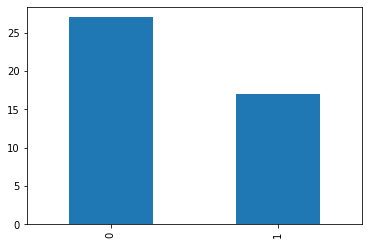

In [ ]:
val_data['label'].value_counts().plot.bar()

val_0 = len(val_data['label']) - sum(map(int, val_data['label']))
val_1 = sum(map(int, val_data['label']))
print("Val: ratio of class 0 to class 1: {0}:1".format(round(val_0/val_1,2)))

Test: ratio of class 0 to class 1: 1.5:1


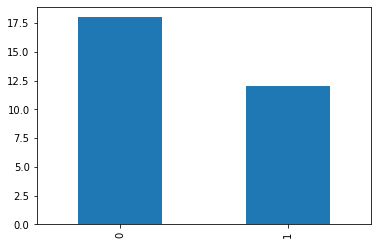

In [ ]:
test_data['label'].value_counts().plot.bar()

test_0 = len(test_data['label']) - sum(map(int, test_data['label']))
test_1 = sum(map(int, test_data['label']))
print("Test: ratio of class 0 to class 1: {0}:1".format(round(test_0/test_1,2)))

#### TRAINING GENERATORS

In [ ]:
train_datagen = image.ImageDataGenerator(
    rescale = 1./255
)

val_datagen = image.ImageDataGenerator(
    rescale = 1./255
)

test_datagen = image.ImageDataGenerator(
    rescale = 1./255
)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train_data, 
    x_col = 'filename',
    y_col = 'label',
    target_size = (IMG_HEIGHT, IMG_WIDTH), 
    color_mode = 'grayscale',
    batch_size = BATCH_SIZE,
    class_mode = 'binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_data, 
    x_col = 'filename',
    y_col = 'label',
    target_size = (IMG_HEIGHT, IMG_WIDTH), 
    color_mode = 'grayscale',
    batch_size = BATCH_SIZE,
    class_mode = 'binary'
)

test_generator = test_datagen.flow_from_dataframe(
    test_data, 
    x_col = 'filename',
    y_col = 'label',
    target_size = (IMG_HEIGHT, IMG_WIDTH), 
    color_mode = 'grayscale',
    batch_size = BATCH_SIZE,
    class_mode = 'binary'
)

Found 222 validated image filenames belonging to 2 classes.
Found 44 validated image filenames belonging to 2 classes.
Found 30 validated image filenames belonging to 2 classes.


#### CREATE AND TRIAN MODEL

In [ ]:
model = createModel()
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 348, 348, 16)      160       
                                                                 
 batch_normalization_60 (Bat  (None, 348, 348, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 174, 174, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 172, 172, 32)      4640      
                                                                 
 batch_normalization_61 (Bat  (None, 172, 172, 32)     128       
 chNormalization)                                                
                                                     

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = len(train_data) // BATCH_SIZE,
    epochs = 50,
    class_weight = {0:1, 1:1.5},
    validation_data = val_generator
    )

Epoch 1/50
6/6 [==============================] - 31s 5s/step - loss: 2.6518 - accuracy: 0.5421 - val_loss: 0.9290 - val_accuracy: 0.3864
Epoch 2/50
6/6 [==============================] - 29s 5s/step - loss: 1.6563 - accuracy: 0.6368 - val_loss: 1.6931 - val_accuracy: 0.3864
Epoch 3/50
6/6 [==============================] - 29s 5s/step - loss: 1.0245 - accuracy: 0.7263 - val_loss: 2.6068 - val_accuracy: 0.3864
Epoch 4/50
6/6 [==============================] - 29s 5s/step - loss: 0.7527 - accuracy: 0.7684 - val_loss: 3.5924 - val_accuracy: 0.3864
Epoch 5/50
6/6 [==============================] - 29s 5s/step - loss: 0.4544 - accuracy: 0.8211 - val_loss: 4.5662 - val_accuracy: 0.3864
Epoch 6/50
6/6 [==============================] - 29s 5s/step - loss: 0.2870 - accuracy: 0.8895 - val_loss: 5.4699 - val_accuracy: 0.3864
Epoch 7/50
6/6 [==============================] - 29s 5s/step - loss: 0.3482 - accuracy: 0.8698 - val_loss: 6.4535 - val_accuracy: 0.3864
Epoch 8/50
6/6 [==================

#### EVALUATE MODEL

In [ ]:
loss, acc = model.evaluate(train_generator)
print("Model, training accuracy: {:5.2f}%".format(100 * acc))
loss, acc = model.evaluate(val_generator)
print("Model, validation accuracy: {:5.2f}%".format(100 * acc))
loss, acc = model.evaluate(test_generator)
print("Model, testing accuracy: {:5.2f}%".format(100 * acc))

7/7 [==============================] - 9s 1s/step - loss: 10.1033 - accuracy: 0.3829
Model, training accuracy: 38.29%
2/2 [==============================] - 2s 369ms/step - loss: 10.4257 - accuracy: 0.3864
Model, validation accuracy: 38.64%
1/1 [==============================] - 1s 1s/step - loss: 10.1707 - accuracy: 0.4000
Model, testing accuracy: 40.00%


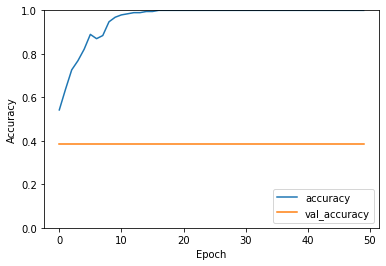

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

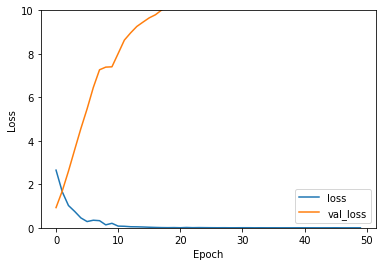

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 10])
plt.legend(loc='lower right')

#### MAKE PREDICTIONS

In [ ]:
predictions = model.predict(test_generator)

Recall/Sensitivity/True positive rate: 1.000
Specificity/selectivity/True negative rate: 0.000
Precision/Positive predictive value: 0.400
Negative predictive value: nan
F1 score: 0.571


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


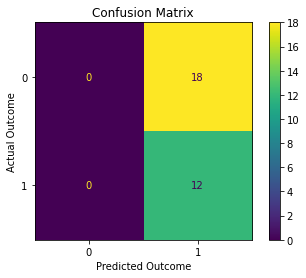

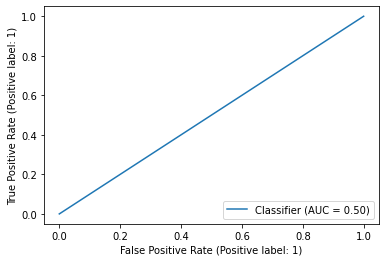

In [ ]:
preds = np.where(predictions > 0.5, 1, 0)
cm = confusion_matrix(test_generator.classes, preds)
tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
ppv = tp / (tp + fp)
npv = tn / (tn + fn)
f1 = 2 * ((ppv * tpr) / (ppv + tpr))

print("Recall/Sensitivity/True positive rate: {:.3f}".format(tpr))
print("Specificity/selectivity/True negative rate: {:.3f}".format(tnr))
print("Precision/Positive predictive value: {:.3f}".format(ppv))
print("Negative predictive value: {:.3f}".format(npv))
print("F1 score: {:.3f}".format(f1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(np.unique(test_generator.classes)))
disp.plot()
disp.ax_.set(
                title='Confusion Matrix', 
                xlabel='Predicted Outcome', 
                ylabel='Actual Outcome')
plt.show()

RocCurveDisplay.from_predictions(test_generator.classes, preds)

#### SAVE MODEL

In [ ]:
model.save_weights("/content/drive/MyDrive/cisc499/checkpoints/left_images_original/")